In [105]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import string
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [106]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

def logPredict(X, w): 
    return sigmoid(np.dot(X,w))

def logAvgCost(X, y, w, regularization=None, lmda=0):
    predict = logPredict(X, w)
    cost = y * np.log(predict) + (1.0 - y) * np.log(1.0 - predict)
    cost = - cost 
    totalCost = cost.sum()
    if regularization == 'l1':
        totalCost += l1Cost(lmda, w)
    elif regularization == 'l2':
        totalCost += l2Cost(lmda, w)
    return totalCost / y.shape[0]

def l1Cost(lmda, w): 
    return lmda * np.sum(np.abs(w))

def l2Cost(lmda, w):
    return lmda * np.sum(np.square(w))

def l1Grad(lmda, w):
    gradient = lmda * np.sign(w)
    zeros = np.array(np.where(gradient == 0)).T
    for zero in zeros:
        gradient[zero] = (2.0 * np.random.rand()) - 1.0
    return gradient

def l2Grad(lmda, w): 
    return lmda * 2 * w

def logAvgGrad(X, y, w, regularization=None, lmda=0):
    predict = logPredict(X, w)
    gradient = np.dot(X.T, predict - y) 
    if regularization == 'l1':
        gradient += l1Grad(lmda, w)
    elif regularization == 'l2':
        gradient += l2Grad(lmda, w)
    return gradient / y.shape[0]

def updateWeightsGD(X, y, w, lr, regularization=None, lmda=0):
    gradient = logAvgGrad(X, y, w, regularization, lmda)
    return w - (lr * gradient)

def trainGD(X, y, lr, numIters, logFreq, regularization=None, lmda=0):
    costs = [] 
    w = np.random.rand(X.shape[1], 1)
    for i in range(numIters):
        cost = logAvgCost(X, y, w, regularization, lmda)
        w = updateWeightsGD(X, y, w, lr, regularization, lmda)
        if i % logFreq == 0: 
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    return w, costs

def trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0):
    uniqueYs = np.unique(y)
    ys = [] 
    for uniqueY in uniqueYs: 
        binaryYs = np.copy(y)
        binaryYs += 1 
        binaryYs[binaryYs != uniqueY + 1] = 0
        binaryYs[binaryYs == uniqueY + 1] = 1
        ys.append(binaryYs)
    ys = np.array(ys)
    ws = np.random.rand(uniqueYs.shape[0],\
        X.shape[1],1)
    costs = []
    for i in range(numIters):
        cost = 0
        for uniqueY in uniqueYs: 
            cost += logAvgCost(X, ys[int(uniqueY)], ws[int(uniqueY)], regularization, lmda)
            ws[int(uniqueY)] = updateWeightsGD(X, ys[int(uniqueY)],\
                ws[int(uniqueY)], lr, regularization, lmda)
        cost /= uniqueYs.shape[0]
        if i % logFreq == 0:
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    costs = np.array(costs)
    return ws, costs  

def updateWeightsAdaGrad(X, y, w, lr, S, epsilon, regularization=None, lmda=0):
    gradient = logAvgGrad(X, y, w, regularization, lmda)
    S += np.square(gradient)
    multiplier = lr / np.sqrt(S + epsilon)
    return w - np.multiply(multiplier, gradient)

def trainAdaGrad(X, y, lr, numIters, logFreq, epsilon, regularization=None, lmda=0):
    costs = [] 
    w = np.random.rand(X.shape[1], 1)
    S = np.zeros((X.shape[1], 1))
    for i in range(numIters):
        cost = logAvgCost(X, y, w, regularization, lmda)
        w = updateWeightsAdaGrad(X, y, w, lr, S, epsilon, regularization, lmda)
        if i % logFreq == 0: 
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    return w, costs

def trainAdaGradMulticlass(X, y, lr, numIters, logFreq, epsilon, regularization=None, lmda=0):
    uniqueYs = np.unique(y)
    ys = [] 
    for uniqueY in uniqueYs: 
        binaryYs = np.copy(y)
        binaryYs += 1 
        binaryYs[binaryYs != uniqueY + 1] = 0
        binaryYs[binaryYs == uniqueY + 1] = 1
        ys.append(binaryYs)
    ys = np.array(ys)
    ws = np.random.rand(uniqueYs.shape[0],\
        X.shape[1],1)
    Ss = np.zeros((uniqueYs.shape[0], X.shape[1], 1))
    costs = []
    for i in range(numIters):
        cost = 0
        for uniqueY in uniqueYs: 
            cost += logAvgCost(X, ys[int(uniqueY)], ws[int(uniqueY)], regularization, lmda)
            ws[int(uniqueY)] = updateWeightsAdaGrad(X, ys[int(uniqueY)],\
                ws[int(uniqueY)], lr, Ss[int(uniqueY)], epsilon, regularization, lmda)
        cost /= uniqueYs.shape[0]
        if i % logFreq == 0:
            print("iter:", i, "cost:", cost)
            costs.append(cost)
    costs = np.array(costs)
    return ws, costs  

def logPredictMulticlass(X, w):
    predictions = [] 
    for i in range(ws.shape[0]):
        predictions.append(logPredict(X,w[i]))
    predictions = np.array(predictions)
    return np.argmax(predictions,axis=0)

def logMulticlassAccuracy(X, w, y):
    predictions = logPredictMulticlass(X, w)
    return np.sum(predictions == y) / y.shape[0]

In [107]:
# Graphing
# Graph generation method
def generateGraph(variable, trainScoresMean, testScoresMean,\
    xLabel, yLabel, title, log=False):
    plt.figure()
    if log is False:
        plt.plot(variable, trainScoresMean, "-o", color="blue",\
            label="Training Accuracy")
        plt.plot(variable, testScoresMean, "-o", color="red",\
            label="Cross-Validation Accuracy")
    else: 
        plt.semilogx(variable, trainScoresMean, "-o",\
            color="blue", label="Training Accuracy")
        plt.semilogx(variable, testScoresMean, "-o",\
            color="red", label="Cross-Validation Accuracy")
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend(loc="lower right")

In [4]:
# MNIST
# Load dataset
digits = load_digits()
digX = digits.images 
digY = digits.target
# Reshape images into 1D vectors 
digX = np.reshape(digX, \
    (digX.shape[0], digX.shape[1] * digX.shape[2]))
# Normalize all images 
for i in range(digX.shape[0]):
    digX[i] = np.divide(digX[i], np.amax(digX,axis=1)[i])

# Split training and test sets 
digXTrain, digXTest, digYTrain, digYTest = \
    train_test_split(digX, digY, test_size=0.20)

# Ensure dimensionality matches 
digYTrain = np.expand_dims(digYTrain, axis=1)
digYTest = np.expand_dims(digYTest, axis=1)

In [5]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(digXTrain,\
    digYTrain, 1, 1000, 100, 'l1', 0.1)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(digXTrain, ws, digYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(digXTest, ws, digYTest))

iter: 0 cost: 8.77854881756744
iter: 100 cost: 0.08095590245294036
iter: 200 cost: 0.062086894233498426
iter: 300 cost: 0.05406510059870266
iter: 400 cost: 0.04938088928443863
iter: 500 cost: 0.04621638987999921
iter: 600 cost: 0.043893169506704494
iter: 700 cost: 0.042092617152552386
iter: 800 cost: 0.0406433344884895
iter: 900 cost: 0.03944531480763955
Accuracy (Training): 0.9791231732776617
Accuracy (Test): 0.9583333333333334


iter: 0 cost: 8.847995475397708
iter: 0 cost: 8.814080299053009
iter: 0 cost: 9.008531282155431
iter: 0 cost: 8.46606991260823
iter: 0 cost: 8.630152693734496
iter: 0 cost: 8.52889307477788
iter: 0 cost: 8.312972225887965
iter: 0 cost: 8.853101234596512
iter: 0 cost: 8.905606584271107
iter: 0 cost: 8.608864183931235
iter: 0 cost: 11.207456547374786
iter: 0 cost: 30.212000071939958
iter: 0 cost: 8.298029617351805
iter: 0 cost: 8.901826214418218
iter: 0 cost: 8.780957465419267
iter: 0 cost: 8.924391614546789
iter: 0 cost: 9.295490491117764
iter: 0 cost: 10.36629213090202
iter: 0 cost: 23.807904254608104


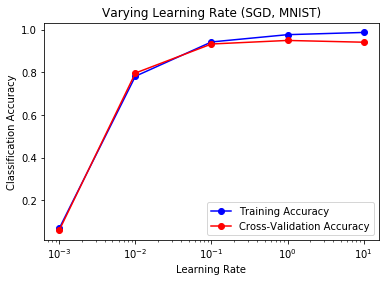

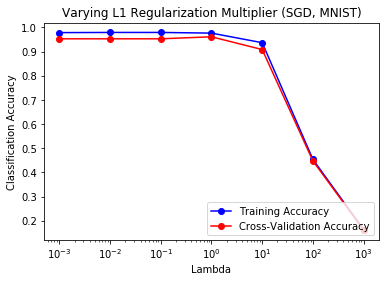

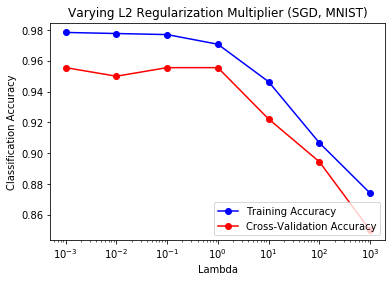

In [6]:
# Evaluation 
# Varying learning rate
# trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0)
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, lr, 1000, 1000)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (SGD, MNIST)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (SGD, MNIST)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (SGD, MNIST)", log=True)

In [7]:
# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(digXTrain,\
    digYTrain, 1, 1000, 100, 1e-8, 'l1', 0.1)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(digXTrain, ws, digYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(digXTest, ws, digYTest))

iter: 0 cost: 8.81208274798026
iter: 100 cost: 0.054009340697247124
iter: 200 cost: 0.04372501359552598
iter: 300 cost: 0.03920484887297905
iter: 400 cost: 0.03650982224572989
iter: 500 cost: 0.03466554351734567
iter: 600 cost: 0.03331124138392634
iter: 700 cost: 0.032259140274376465
iter: 800 cost: 0.031410074333036
iter: 900 cost: 0.03070947247884258
Accuracy (Training): 0.9860821155184412
Accuracy (Test): 0.9527777777777777


iter: 0 cost: 8.712908274089683
iter: 0 cost: 8.608063469826243
iter: 0 cost: 8.777988890837428
iter: 0 cost: 8.761296945715477
iter: 0 cost: 9.060294428135688


C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


iter: 0 cost: 8.994448298848432
iter: 0 cost: 9.049540736369329
iter: 0 cost: 8.77171673679381
iter: 0 cost: 8.844293604176697
iter: 0 cost: 9.454347071784339
iter: 0 cost: 10.414701675621535
iter: 0 cost: 31.348309248662513
iter: 0 cost: 8.979066287116392
iter: 0 cost: 8.85687585660642
iter: 0 cost: 9.3761335697069
iter: 0 cost: 9.175036261501809
iter: 0 cost: 8.70741563203748
iter: 0 cost: 10.189164035216134
iter: 0 cost: 23.01552414002587


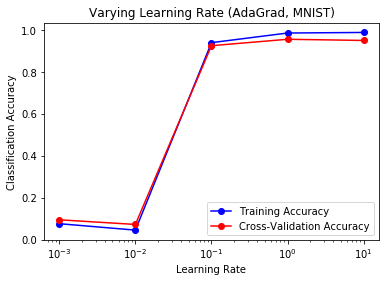

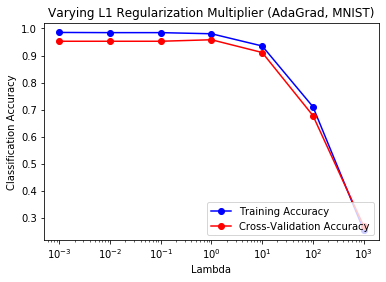

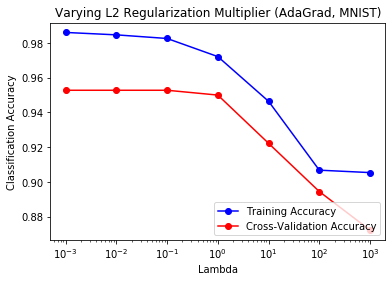

In [8]:
# Evaluation 
# Varying learning rate
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, lr, 1000, 1000, 1e-8)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (AdaGrad, MNIST)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, 1e-8, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (AdaGrad, MNIST)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(digXTrain,\
        digYTrain, 1, 1000, 1000, 1e-8, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(digXTrain, ws, digYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(digXTest, ws, digYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (AdaGrad, MNIST)", log=True)

In [9]:
# Sentiment classification  
# on the Twitter US Airline Sentiment Dataset 
tweets = pd.read_csv('./Tweets.csv', sep=',')

# Process labels 
textYRaw = np.array(tweets['airline_sentiment'])
textY = np.zeros(textYRaw.shape)
# Convert y categories into numerical values 
textY[textYRaw == 'negative'] = 0 
textY[textYRaw == 'neutral'] = 1
textY[textYRaw == 'positive'] = 2
textY = np.expand_dims(textY, axis=1)

# Clean text 
textXRaw = tweets['text'].tolist()
textXCleaned = []
for i in range(len(textXRaw)):
    rawText = textXRaw[i]
    # Set all lower case
    processed = rawText.lower()
    # Remove twitter tags 
    processed = " ".join(filter(lambda x:x[0] !='@', processed.split()))
    # Remove numbers 
    processed = re.sub(r'\d+','',processed)
    # Remove punctuation
    processed = processed.translate(str.maketrans("","", string.punctuation))
    # Remove whitespaces 
    processed = processed.strip()
    textXCleaned.append(processed)

# Split into training and test sets 
# Split training and test sets 
textXTrainText, textXTestText, textYTrain, textYTest = \
    train_test_split(textXCleaned, textY, test_size=0.20)

# Use the top 500 most frequently appearing 
# words for classification
# Bag of words approach: 
vectorizer = CountVectorizer(max_features=1000)
textXTrainCounts = vectorizer.fit_transform(textXTrainText)
# tf-idf: term frequency-inverse document frequency 
tfTransformer = TfidfTransformer()
textXTrain = tfTransformer.fit_transform(textXTrainCounts)
textXTrain = textXTrain.toarray()
textXTestCounts = vectorizer.transform(textXTestText)
textXTest = tfTransformer.fit_transform(textXTestCounts)
textXTest = textXTest.toarray()

# textXTrain, textYTrain, textXTest, textYTest

# Our method of vectorizing text input from scratch
# Assume cleaned input (no punctuation, same case, etc.)
def vectorizeText(XCleaned):
    # Tokenize text 
    XTokenized = [] 
    stopWords = stopwords.words('english')
    wordnetLemmatizer = WordNetLemmatizer()
    for i in range(len(XCleaned)):
        tokens = nltk.word_tokenize(XCleaned[i])
        # Remove stop words 
        tokens = [j for j in tokens if not j in stopWords]
        # Lemmatize 
        tokens = [wordnetLemmatizer.lemmatize(word) for word in tokens]
        XTokenized.append(tokens)

    allTokens = [token for sublist in XTokenized for token in sublist]
    allTokens = np.array(allTokens)
    unique, count = np.unique(allTokens, return_counts=True)
    count, unique = zip(*sorted(zip(count, unique)))

    # Number of features to consider 
    nFeatures = 500
    textFeatures = unique[len(unique)-nFeatures:]

In [10]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(textXTrain, textYTrain, 1, 10000, 1000)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 0 cost: 1.2651680681469515
iter: 1000 cost: 0.407404074083139
iter: 2000 cost: 0.36419620965069077
iter: 3000 cost: 0.3423882626041415
iter: 4000 cost: 0.3287748308345172
iter: 5000 cost: 0.31926890942898795
iter: 6000 cost: 0.3121548090677935
iter: 7000 cost: 0.306575481921357
iter: 8000 cost: 0.30205063716591796
iter: 9000 cost: 0.2982879237731397
Accuracy (Training): 0.8220628415300546
Accuracy (Test): 0.7800546448087432


iter: 0 cost: 1.308218793862303
iter: 0 cost: 1.282995860308308
iter: 0 cost: 1.3003515852153678
iter: 0 cost: 1.2606791413546998
iter: 0 cost: 1.267029517799678
iter: 0 cost: 1.2831844630970155
iter: 0 cost: 1.2914690851319153
iter: 0 cost: 1.2802328001238654
iter: 0 cost: 1.2950192318089124
iter: 0 cost: 1.7102003593452864
iter: 0 cost: 5.534169485238919
iter: 0 cost: 43.918285209197656
iter: 0 cost: 1.2805749771577128
iter: 0 cost: 1.2750157443818655
iter: 0 cost: 1.2425681957544608
iter: 0 cost: 1.2714598925999814
iter: 0 cost: 1.5228380409575848
iter: 0 cost: 4.085536186422815
iter: 0 cost: 29.345260209095628


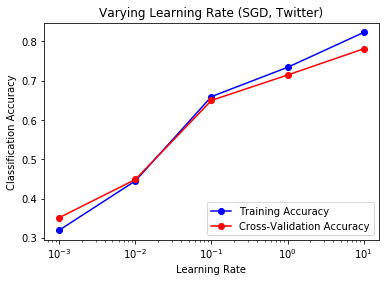

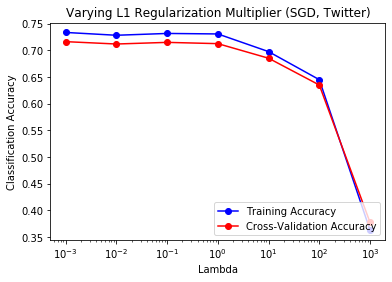

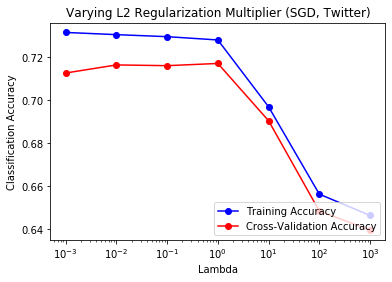

In [11]:
# Evaluation 
# Varying learning rate
# trainGDMulticlass(X, y, lr, numIters, logFreq, regularization=None, lmda=0)
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, lr, 1000, 1000)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (SGD, Twitter)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (SGD, Twitter)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # Gradient Descent Training
    ws, costs = trainGDMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (SGD, Twitter)", log=True)

In [13]:
# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(textXTrain,\
    textYTrain, 1, 1000, 100, 1e-8)

# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 0 cost: 1.2949280646723274
iter: 100 cost: 0.26145073080581177
iter: 200 cost: 0.25741497731413715
iter: 300 cost: 0.2561198680092012
iter: 400 cost: 0.25550834478147816
iter: 500 cost: 0.2551607702496544
iter: 600 cost: 0.2549399237589293
iter: 700 cost: 0.25478868081199807
iter: 800 cost: 0.25467935523013147
iter: 900 cost: 0.2545970286373169
Accuracy (Training): 0.8434084699453552
Accuracy (Test): 0.7745901639344263


iter: 0 cost: 1.242291406252164
iter: 0 cost: 1.2852101687986672
iter: 0 cost: 1.278134280821391
iter: 0 cost: 1.228226412191933
iter: 0 cost: 1.2956172104035772


C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\ychen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


iter: 0 cost: 1.274353517392312
iter: 0 cost: 1.2946233518636063
iter: 0 cost: 1.246339278943034
iter: 0 cost: 1.3427091381660532
iter: 0 cost: 1.6589148962800835
iter: 0 cost: 5.481386959253446
iter: 0 cost: 43.674199137439835
iter: 0 cost: 1.2709303896769628
iter: 0 cost: 1.2814547416358726
iter: 0 cost: 1.234155936847199
iter: 0 cost: 1.279156120933625
iter: 0 cost: 1.5707626634400782
iter: 0 cost: 4.148920367044411
iter: 0 cost: 29.610965354204648


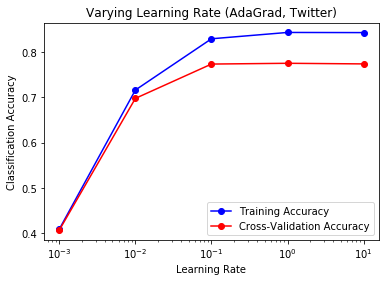

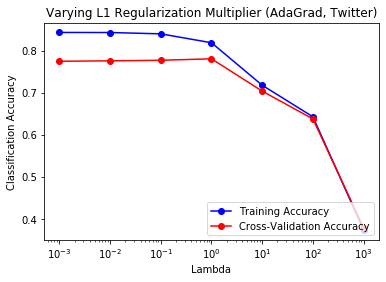

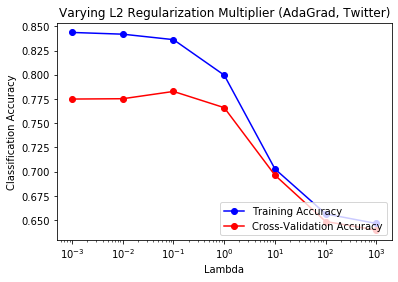

In [14]:
# Evaluation 
# Varying learning rate
lrs = np.logspace(-3,1,5)
varyLRTrainAccuracy = [] 
varyLRTestAccuracy = []
for lr in lrs: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, lr, 1000, 1000, 1e-8)
    # Evaluation 
    varyLRTrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLRTestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lrs, varyLRTrainAccuracy, varyLRTestAccuracy,\
    "Learning Rate", "Classification Accuracy", "Varying Learning Rate (AdaGrad, Twitter)", log=True)

lmbdas = np.logspace(-3,3,7)
# Varying l1 multiplier 
varyLmbdasL1TrainAccuracy = [] 
varyLmbdasL1TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, 1e-8, regularization="l1", lmda=lmbda)
    # Evaluation 
    varyLmbdasL1TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL1TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL1TrainAccuracy, varyLmbdasL1TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L1 Regularization Multiplier (AdaGrad, Twitter)", log=True)

# Varying l2 multiplier 
varyLmbdasL2TrainAccuracy = [] 
varyLmbdasL2TestAccuracy = []
for lmbda in lmbdas: 
    # AdaGrad
    ws, costs = trainAdaGradMulticlass(textXTrain,\
        textYTrain, 1, 1000, 1000, 1e-8, regularization="l2", lmda=lmbda)
    # Evaluation 
    varyLmbdasL2TrainAccuracy.append(logMulticlassAccuracy(textXTrain, ws, textYTrain))
    varyLmbdasL2TestAccuracy.append(logMulticlassAccuracy(textXTest, ws, textYTest))

generateGraph(lmbdas, varyLmbdasL2TrainAccuracy, varyLmbdasL2TestAccuracy,\
    "Lambda", "Classification Accuracy", "Varying L2 Regularization Multiplier (AdaGrad, Twitter)", log=True)

In [15]:
# Learning curve comparison with ideal parameters 
dataPercs = np.linspace(0.2,1.0,5)

GDTrainAccDigit = []
GDTestAccDigit = []
GDTrainAccText = []
GDTestAccText = []

AdaGradTrainAccDigit = []
AdaGradTestAccDigit = []
AdaGradTrainAccText = []
AdaGradTestAccText = []

for dataPerc in dataPercs: 
    textXNumExamples = int(dataPerc * textXTrain.shape[0])
    digXNumExamples = int(dataPerc * digXTrain.shape[0])
    
    # Gradient Descent 
    ws, costs = trainGDMulticlass(digXTrain[:digXNumExamples],\
        digYTrain[:digXNumExamples], 1, 1000, 1000, regularization='l2', lmda=0.1)
    GDTrainAccDigit.append(logMulticlassAccuracy(digXTrain[:digXNumExamples],\
        ws, digYTrain[:digXNumExamples]))
    GDTestAccDigit.append(logMulticlassAccuracy(digXTest, ws, digYTest))
    
    ws, costs = trainGDMulticlass(textXTrain[:textXNumExamples],\
        textYTrain[:textXNumExamples], 1, 1000, 1000, regularization='l2', lmda=0.1)
    GDTrainAccText.append(logMulticlassAccuracy(textXTrain[:textXNumExamples],\
        ws, textYTrain[:textXNumExamples]))
    GDTestAccText.append(logMulticlassAccuracy(textXTest, ws, textYTest))
    
    # Gradient Descent 
    ws, costs = trainAdaGradMulticlass(digXTrain[:digXNumExamples],\
        digYTrain[:digXNumExamples], 1, 1000, 1000, 1e-8, regularization='l2', lmda=0.1)
    AdaGradTrainAccDigit.append(logMulticlassAccuracy(digXTrain[:digXNumExamples],\
        ws, digYTrain[:digXNumExamples]))
    AdaGradTestAccDigit.append(logMulticlassAccuracy(digXTest, ws, digYTest))
    
    ws, costs = trainAdaGradMulticlass(textXTrain[:textXNumExamples],\
        textYTrain[:textXNumExamples], 1, 1000, 1000, 1e-8, regularization='l2', lmda=0.1)
    AdaGradTrainAccText.append(logMulticlassAccuracy(textXTrain[:textXNumExamples],\
        ws, textYTrain[:textXNumExamples]))
    AdaGradTestAccText.append(logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 0 cost: 8.455741508084333
iter: 0 cost: 1.2681097271390696
iter: 0 cost: 8.714166833447209
iter: 0 cost: 1.2915190783464003
iter: 0 cost: 8.461276012237239
iter: 0 cost: 1.280020832088051
iter: 0 cost: 9.000764431227147
iter: 0 cost: 1.2893225785945293
iter: 0 cost: 8.679413460110059
iter: 0 cost: 1.299759795350633
iter: 0 cost: 8.462744740478449
iter: 0 cost: 1.2636979041336867
iter: 0 cost: 8.775571956683185
iter: 0 cost: 1.252674006047496
iter: 0 cost: 9.084752957055612
iter: 0 cost: 1.2963963488483496
iter: 0 cost: 8.84986683059646
iter: 0 cost: 1.2450016768272396
iter: 0 cost: 9.047671356531616
iter: 0 cost: 1.2890578275537867


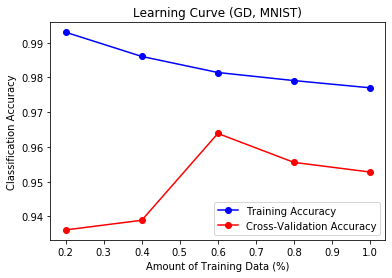

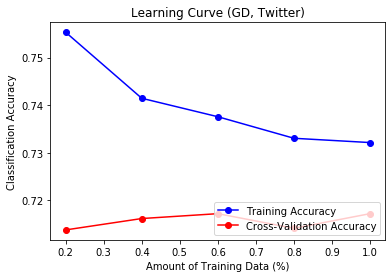

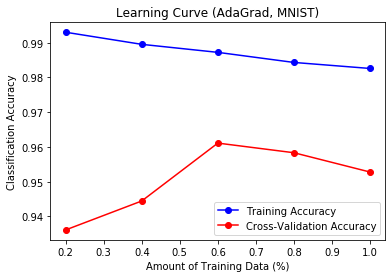

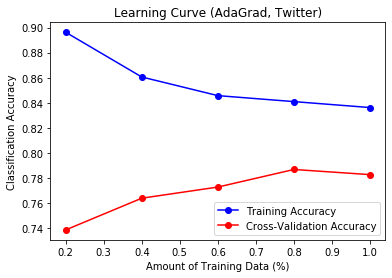

In [19]:
generateGraph(dataPercs, GDTrainAccDigit, GDTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, MNIST)")
generateGraph(dataPercs, GDTrainAccText, GDTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, Twitter)")
generateGraph(dataPercs, AdaGradTrainAccDigit, AdaGradTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, MNIST)")
generateGraph(dataPercs, AdaGradTrainAccText, AdaGradTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, Twitter)")

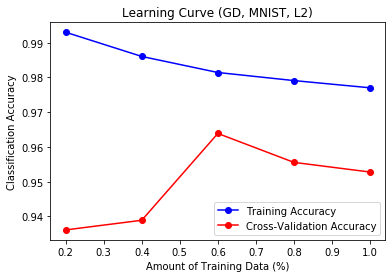

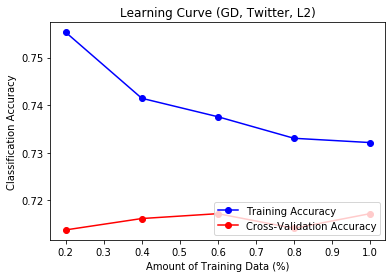

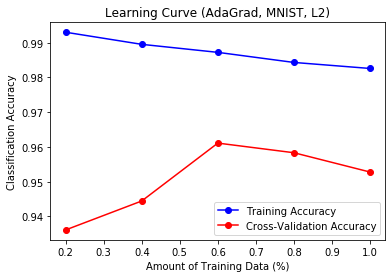

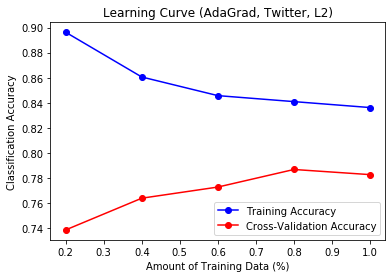

In [70]:
generateGraph(dataPercs, GDTrainAccDigit, GDTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, MNIST, L2)")
generateGraph(dataPercs, GDTrainAccText, GDTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (GD, Twitter, L2)")
generateGraph(dataPercs, AdaGradTrainAccDigit, AdaGradTestAccDigit,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, MNIST, L2)")
generateGraph(dataPercs, AdaGradTrainAccText, AdaGradTestAccText,\
    "Amount of Training Data (%)", "Classification Accuracy", "Learning Curve (AdaGrad, Twitter, L2)")

In [158]:
# Gradient Descent Training
ws, costs = trainGDMulticlass(textXTrain, textYTrain, 1, 1000, 50)
# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

# AdaGrad Training 
ws, costs = trainAdaGradMulticlass(textXTrain,\
    textYTrain, 1, 1000, 50, 1e-8)
# Evaluation 
print("Accuracy (Training):",
    logMulticlassAccuracy(textXTrain, ws, textYTrain))
print("Accuracy (Test):",\
    logMulticlassAccuracy(textXTest, ws, textYTest))

iter: 0 cost: 1.2976122133494548
iter: 50 cost: 0.849630830905999
iter: 100 cost: 0.656547145941627
iter: 150 cost: 0.5742695944045612
iter: 200 cost: 0.5328907418187278
iter: 250 cost: 0.5083336265906678
iter: 300 cost: 0.4916908947217009
iter: 350 cost: 0.4792372202903245
iter: 400 cost: 0.46923890661631895
iter: 450 cost: 0.46081357809682993
iter: 500 cost: 0.453476025959175
iter: 550 cost: 0.4469403865758501
iter: 600 cost: 0.4410273385968077
iter: 650 cost: 0.4356177480020121
iter: 700 cost: 0.43062823033257147
iter: 750 cost: 0.42599764641721044
iter: 800 cost: 0.4216793210318186
iter: 850 cost: 0.41763638480686044
iter: 900 cost: 0.41383888408077424
iter: 950 cost: 0.41026192468983697
Accuracy (Training): 0.7294228142076503
Accuracy (Test): 0.7175546448087432
iter: 0 cost: 1.2627011079048402
iter: 50 cost: 0.2693112476525809
iter: 100 cost: 0.2614798845291339
iter: 150 cost: 0.25874808475884564
iter: 200 cost: 0.2573991223975075
iter: 250 cost: 0.25661117891679547
iter: 300 cost

In [182]:
# Exponential Weights Implementation
# Parameter N
def calcVote(x, w): 
    return sigmoid(np.multiply(w,x))
    
def trainExponential(X, y, N, numIter):
    N = 0.01 # Parameter N
    w = np.ones((X.shape[1], 1)) # Initialize weights 
    numTrain = X.shape[0]
    for j in range(numIter):
        for i in range(numTrain):
            sample = X[i]
            sample = np.expand_dims(sample, axis=1)
            sampleY = y[i]
            votes = sigmoid(sample)
            majorityVote = np.average(votes, weights=w)
            perExpertVoteCost = sampleY * np.log(votes) + (1.0 - sampleY) * np.log(1.0 - votes)
            perExpertVoteCost = - perExpertVoteCost
            weightUpdate = np.exp(- N * perExpertVoteCost)
            updatedW = np.multiply(w, weightUpdate)
            w[np.sign(votes - 0.5) == np.sign(sampleY)] = updatedW[np.sign(votes - 0.5) == np.sign(sampleY)] 
    return w

def predictExponential(X, w):
    #XExpand = np.expand_dims(X, axis=2)
    #vote = sigmoid(np.multiply(XExpand,w))
    vote = logPredict(X,w)
    #majorityVote = np.dot(votes, w) / np.sum(w)
    predictions = np.sign(vote)
    return predictions 

digYTrainOnes = np.copy(digYTrain)
digYTrainOnes[digYTrainOnes != 1] = 0
digYTestOnes = np.copy(digYTest)
digYTestOnes[digYTestOnes != 1] = 0
w = trainExponential(digXTrain, digYTrainOnes, N, 2)
predictY = predictExponential(digXTest, w)
print(np.mean(predictY == digYTestOnes))

0.11666666666666667
